# Import Packages and Construct Bitome

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import f_oneway, mannwhitneyu
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

sys.path.append('../../bitome2')
sys.path.append('../')

from bitome.core import Bitome
from bitome.ml import *
from bitome.util import create_motif, genome_point_to_point, score_motif_match

In [2]:
M_FLORUM_DATA_PATH = Path('../data/bitome2/m_florum')

In [3]:
# terminus is assumed to be at the opposite end from the origin
m_florum = Bitome(
    Path(M_FLORUM_DATA_PATH, 'Mesoplasma_florum_L1.fasta'),
    name='M. florum',
    origin=(1, 1), terminus=(396612, 396612),
    gene_table=Path(M_FLORUM_DATA_PATH, 'gene.csv'),
    terminator_table=Path(M_FLORUM_DATA_PATH, 'terminator.csv'),
    tss_table=Path(M_FLORUM_DATA_PATH, 'tss.csv'),
    tu_table=Path(M_FLORUM_DATA_PATH, 'tu.csv')
)

# Expression Distribution

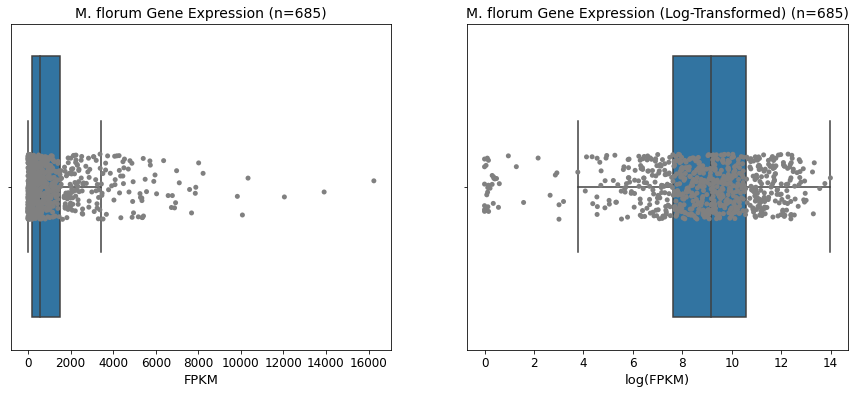

In [4]:
m_florum.expression_distribution();

# TU Expression Overview

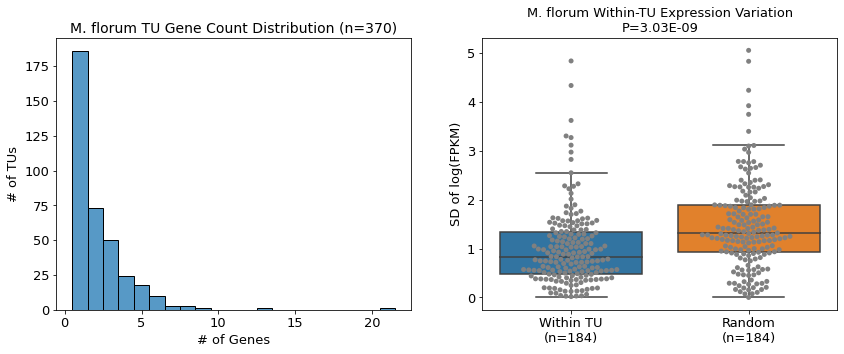

In [5]:
m_florum.within_tu_expression();

## Diverging Promoters

Text(0.8, 0.2, 'P=0.809')

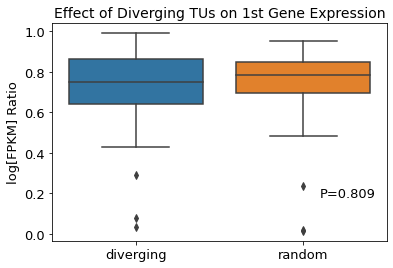

In [6]:
sorted_tu_table = m_florum.tu_table.copy().sort_values(by='tss')

i = 0

ratios = []
rand_ratios = []

while i < sorted_tu_table.shape[0] - 1:
    
    tu_row_a = sorted_tu_table.iloc[i, :]
    tu_row_b = sorted_tu_table.iloc[i+1, :]
    
    # this is the only way to have back-to-back, if we go along the positive strand
    if tu_row_a.strand == -1 and tu_row_b.strand == 1:

        tu_row_a_genes = tu_row_a.gene_names.split(';')
        tu_a_gene_df = m_florum.gene_table[m_florum.gene_table.index.isin(tu_row_a_genes)]
        tu_row_b_genes = tu_row_b.gene_names.split(';')
        tu_b_gene_df = m_florum.gene_table[m_florum.gene_table.index.isin(tu_row_b_genes)]
        
        if not tu_a_gene_df.empty and not tu_b_gene_df.empty:
            tu_a_exp = tu_a_gene_df.sort_values(by='right', ascending=False).iloc[0, :]['log_fpkm']
            tu_b_exp = tu_b_gene_df.sort_values(by='left').iloc[0, :]['log_fpkm']
        
            ratio = min(tu_a_exp, tu_b_exp) / max(tu_a_exp, tu_b_exp)
            ratios.append(ratio)
            rand_exps = np.random.choice(m_florum.gene_table['log_fpkm'], size=2)
            rand_ratio = min(rand_exps) / max(rand_exps)
            rand_ratios.append(rand_ratio)
            
            i += 2
        else:
            i += 1
    else:
        i += 1
        
diverge_df = pd.DataFrame(data={'log[FPKM] Ratio': ratios + rand_ratios,
                               'source': ['diverging'] * len(ratios) + ['random'] * len(rand_ratios)})

_, ax = plt.subplots()

u_stat, p_value = mannwhitneyu(ratios, rand_ratios, alternative='two-sided')

sns.boxplot(x='source', y='log[FPKM] Ratio', data=diverge_df, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('log[FPKM] Ratio', fontsize=13)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('Effect of Diverging TUs on 1st Gene Expression', fontsize=14)
ax.text(0.8, 0.2, f'P={p_value:.3f}', transform=ax.transAxes, fontsize=13)

# TSS Alignment Investigation

We know that many genes are transcribed from multiple TSSes:
- what are the relative strengths of these TSSes? 
- should we average the one-hot sequence of all TSSes for a gene, or use the strongest?
- should we align multiple TSS at the TSS itself, or at the -10 box location?

We're using RSPM to assess signal strength

RSPM = number of read starts per million of mapped reads

## Relative TSS Strength for Multi-TSS Genes

Text(0.5, 1.0, 'Relative Strengths of Minor TSSes')

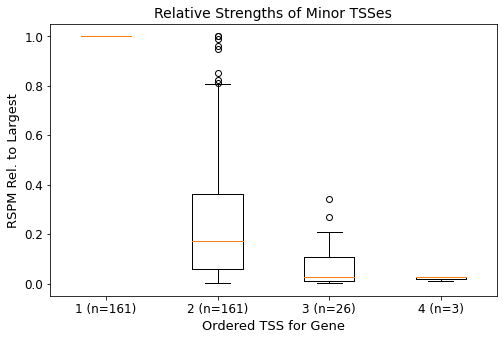

In [7]:
tss_rspm_by_gene = []

for gene_row in m_florum.gene_table.itertuples():
    tus_for_gene = m_florum._gene_to_tus[gene_row.Index]
    if len(tus_for_gene) > 1:
        gene_tu_df = m_florum.tu_table.loc[tus_for_gene, :]
        gene_tsses = gene_tu_df['tss']
        gene_tss_df = m_florum.tss_table[m_florum.tss_table['tss'].isin(gene_tsses)]
        if gene_tss_df.shape[0] > 1:
            tss_rspm_by_gene.append(list(gene_tss_df['rspm']))
        
rspm_stepdowns = {0: [1]*len(tss_rspm_by_gene)}

for g_rspms in tss_rspm_by_gene:
    rspm_sort = sorted(g_rspms, reverse=True)
    for i in range(1, len(rspm_sort)):
        if i in rspm_stepdowns:
            rspm_stepdowns[i].append(rspm_sort[i]/rspm_sort[0])
        else:
            rspm_stepdowns[i] = [rspm_sort[i]/rspm_sort[0]]
            
_, ax = plt.subplots(figsize=(8, 5))

ax.boxplot(list(rspm_stepdowns.values()))
ax.set_xticklabels([f'{i+1} (n={len(vals)})' for i, vals in enumerate(rspm_stepdowns.values())])
ax.set_xlabel('Ordered TSS for Gene', fontsize=13)
ax.set_ylabel('RSPM Rel. to Largest', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.set_title('Relative Strengths of Minor TSSes', fontsize=14)

So we're seeing that the secondary TSSes have a side range but are mostly much weaker than the primary. Tertiary and quaternary TSS are much less strong. Perhaps we should exclude the 3rd and 4th TSS where applicable (not many)

## TSS Distances

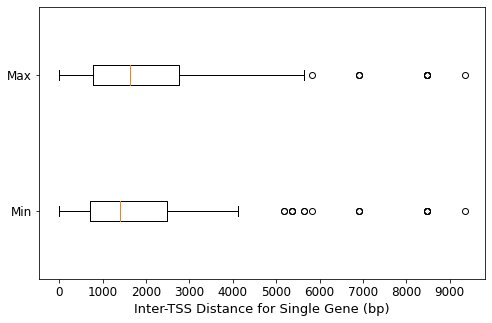

In [8]:
tss_min_ranges = []
tss_max_ranges = []

for gene_row in m_florum.gene_table.itertuples():
    tus_for_gene = m_florum._gene_to_tus[gene_row.Index]
    if len(tus_for_gene) > 1:
        gene_tu_df = m_florum.tu_table.loc[tus_for_gene, :]
        gene_tsses = sorted(list(gene_tu_df['tss']))
        diffs = np.array(gene_tsses[1:]) - np.array(gene_tsses[:-1])
        tss_min_ranges.append(min(diffs))
        tss_max_ranges.append(max(diffs))
        
_, ax = plt.subplots(figsize=(8, 5))

ax.boxplot([tss_min_ranges, tss_max_ranges], vert=False)
ax.set_yticklabels(['Min', 'Max'])
ax.set_xticks(np.arange(0, 10000, 1000))
ax.set_xlabel('Inter-TSS Distance for Single Gene (bp)', fontsize=13)
ax.tick_params(axis='both', labelsize=12)

## TSS to -10 Box Distances

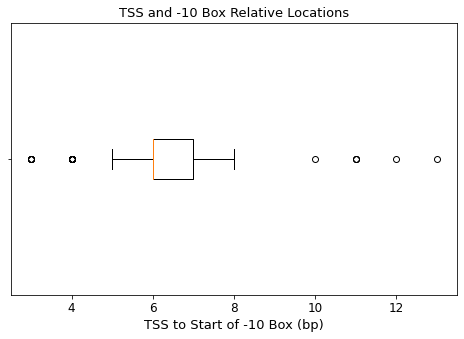

In [9]:
_, ax = plt.subplots(figsize=(8, 5))

ax.boxplot(m_florum.tss_table['tss_box_10_dist'], vert=False)
ax.set_yticklabels([''])
ax.set_xlabel('TSS to Start of -10 Box (bp)', fontsize=13)
ax.set_title('TSS and -10 Box Relative Locations', fontsize=13)
ax.tick_params(axis='both', labelsize=12)

This suggests that we may want to align promoters at the -10 box and not at the TSS for the same gene. We will do so below.

# Modeling - One-Hot Features Only

## Prepare Feature Matrices

In [10]:
N_UP, N_DOWN = 50, 10

one_hot_tus = m_florum.one_hot_encode_tu_promoters(local_align=False, n_upstream=50, n_downstream=10)

In [11]:
Xy_to_try = {}

### TU Expression-Based

Averaged Across all TU Genes (tu_avg)

TU Expression of First Gene (tu_first)

In [12]:
tu_names = []
tu_avgs = []
tu_first_exps = []

for tu_tag in one_hot_tus.index:
    tu_genes = m_florum._tu_to_genes[tu_tag]
    if len(tu_genes) > 0:
        tu_names.append(tu_tag)
        tu_gene_df = m_florum.gene_table.loc[tu_genes, :]
        # do the averaging of all tus
        tu_avgs.append(np.mean(tu_gene_df['fpkm']))
        # figure out the first gene in the TU and just record that
        first_gene_exp = tu_gene_df[tu_gene_df['left'] == min(tu_gene_df['left'])].iloc[0, :]['fpkm']
        tu_first_exps.append(first_gene_exp)
        

X_tu_avg = one_hot_tus.loc[tu_names, :]
y_tu_avg = pd.Series(tu_avgs, index=tu_names)
Xy_to_try['tu_avg'] = (X_tu_avg, y_tu_avg)

X_tu_first = one_hot_tus.loc[tu_names, :]
y_tu_first = pd.Series(tu_first_exps, index=tu_names)
Xy_to_try['tu_first'] = (X_tu_first, y_tu_first)

### Gene Expression-Based

Using Average of Promoters for All TUs Containing Gene (gene_prom_avg)
- also with promoters aligned by -10 box and not TSS (gene_prom_avg_m10)

Using strongest TSS for each gene (gene_strong_tss)

In [13]:
M10_UP = 44
M10_DOWN = 16

gene_names = []
gene_names_m10 = []
gene_one_hot_promoter_rows = []
gene_oh_prom_m10_rows = []
gene_one_hot_prom_rows_strong = []

gene_exps = []
gene_exps_m10 = []

for gene_row in m_florum.gene_table.itertuples():
    tus_for_gene = m_florum._gene_to_tus[gene_row.Index]
    if tus_for_gene:
        
        tu_one_hots = one_hot_tus.loc[tus_for_gene, :]
        tu_one_hot_avg = tu_one_hots.mean(axis=0)
        gene_one_hot_promoter_rows.append(tu_one_hot_avg)
        
        gene_tu_df = m_florum.tu_table.loc[tus_for_gene, :]
        
        m10_one_hots = []
        for tu_row in gene_tu_df.itertuples():
            if not pd.isna(tu_row.box_10_right):
                if tu_row.strand == 1:
                    m10_anchor = tu_row.box_10_right
                    m10_one_hot = m_florum.one_hot_encode_sequence(m10_anchor-M10_UP, m10_anchor+M10_DOWN, 1)
                    m10_one_hots.append(m10_one_hot)
                else:
                    m10_anchor = tu_row.box_10_left
                    m10_one_hot = m_florum.one_hot_encode_sequence(m10_anchor-M10_DOWN, m10_anchor+M10_UP, -1)
                    m10_one_hots.append(m10_one_hot)
        if m10_one_hots:
            gene_names_m10.append(gene_row.Index)
            gene_exps_m10.append(gene_row.fpkm)
            m10_oh_avg_row = pd.DataFrame(m10_one_hots).mean(axis=0)
            gene_oh_prom_m10_rows.append(m10_oh_avg_row)
        
        strong_tu = gene_row.primary_tu
        strong_tu_oh = one_hot_tus.loc[strong_tu, :]
        gene_one_hot_prom_rows_strong.append(strong_tu_oh)
        
        gene_names.append(gene_row.Index)
        gene_exps.append(gene_row.fpkm)

X_gene_prom_avg = pd.DataFrame(gene_one_hot_promoter_rows, index=gene_names)
y_prom_avg = pd.Series(gene_exps, index=gene_names)
Xy_to_try['gene_prom_avg'] = (X_gene_prom_avg, y_prom_avg)

X_gene_prom_avg_m10 = pd.DataFrame(gene_oh_prom_m10_rows, index=gene_names_m10)
y_prom_avg_m10 = pd.Series(gene_exps_m10, index=gene_names_m10)
Xy_to_try['gene_prom_avg_m10'] = (X_gene_prom_avg_m10, y_prom_avg_m10)

X_strong_tss = pd.DataFrame(gene_one_hot_prom_rows_strong, index=gene_names)
y_strong_tss = pd.Series(gene_exps, index=gene_names)
Xy_to_try['gene_strong_tss'] = (X_strong_tss, y_strong_tss)

### Finalize XY to Use

In [14]:
del Xy_to_try['tu_avg']
del Xy_to_try['tu_first']
del Xy_to_try['gene_prom_avg']
del Xy_to_try['gene_prom_avg_m10']

### Set Aside Lockbox Data

In [15]:
Xy_train, Xy_lockbox = create_train_and_lockbox_sets(Xy_to_try)

## Profile Models

In [16]:
models_to_try = {
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RF': RandomForestRegressor(n_jobs=4),
    'NN': MLPRegressor()
}

ElasticNet: gene_strong_tss__X_raw__y_raw
ElasticNet: gene_strong_tss__X_raw__y_standard
ElasticNet: gene_strong_tss__X_raw__y_log
ElasticNet: gene_strong_tss__X_raw__y_standard_log
ElasticNet: gene_strong_tss__X_standard__y_raw
ElasticNet: gene_strong_tss__X_standard__y_standard
ElasticNet: gene_strong_tss__X_standard__y_log
ElasticNet: gene_strong_tss__X_standard__y_standard_log
SVR: gene_strong_tss__X_raw__y_raw
SVR: gene_strong_tss__X_raw__y_standard
SVR: gene_strong_tss__X_raw__y_log
SVR: gene_strong_tss__X_raw__y_standard_log
SVR: gene_strong_tss__X_standard__y_raw
SVR: gene_strong_tss__X_standard__y_standard
SVR: gene_strong_tss__X_standard__y_log
SVR: gene_strong_tss__X_standard__y_standard_log
RF: gene_strong_tss__X_raw__y_raw
RF: gene_strong_tss__X_raw__y_standard
RF: gene_strong_tss__X_raw__y_log
RF: gene_strong_tss__X_raw__y_standard_log
RF: gene_strong_tss__X_standard__y_raw
RF: gene_strong_tss__X_standard__y_standard
RF: gene_strong_tss__X_standard__y_log
RF: gene_strong_

40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


(         model                                           xy  train_score  \
 0   ElasticNet                gene_strong_tss__X_raw__y_raw     0.270546   
 1   ElasticNet                gene_strong_tss__X_raw__y_raw     0.293097   
 2   ElasticNet                gene_strong_tss__X_raw__y_raw     0.281414   
 3   ElasticNet                gene_strong_tss__X_raw__y_raw     0.282724   
 4   ElasticNet                gene_strong_tss__X_raw__y_raw     0.266318   
 ..         ...                                          ...          ...   
 0           NN  gene_strong_tss__X_standard__y_standard_log     0.849038   
 1           NN  gene_strong_tss__X_standard__y_standard_log     0.848090   
 2           NN  gene_strong_tss__X_standard__y_standard_log     0.817589   
 3           NN  gene_strong_tss__X_standard__y_standard_log     0.809598   
 4           NN  gene_strong_tss__X_standard__y_standard_log     0.818380   
 
     val_score  
 0    0.157181  
 1    0.048209  
 2    0.127963  
 3    

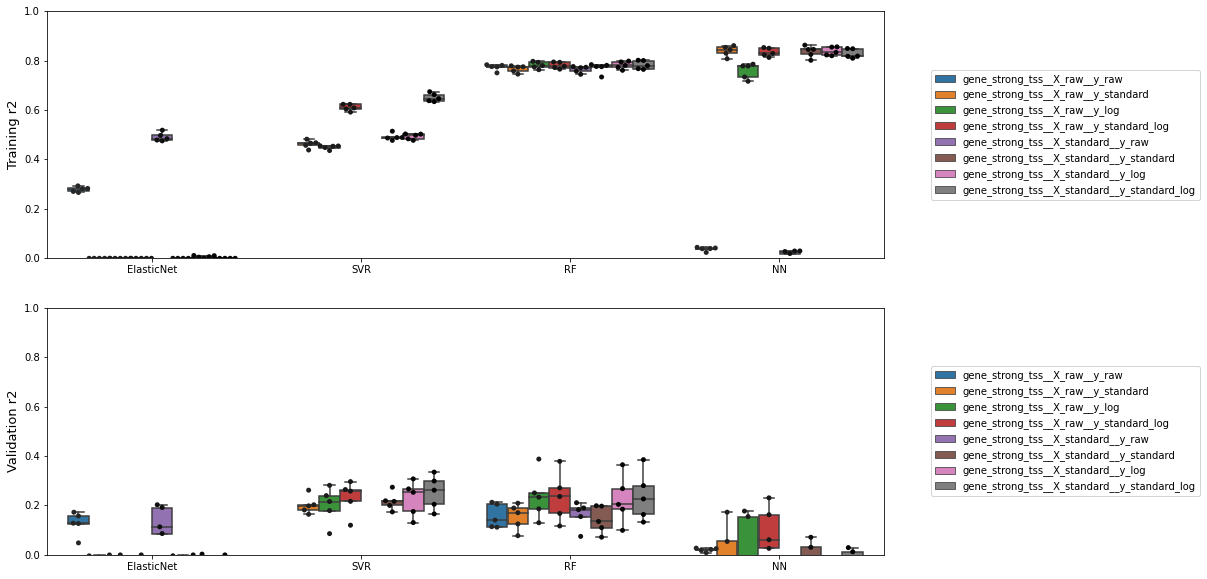

In [17]:
profile_xy_and_models(Xy_train, models_to_try, scoring='r2', n_cv=5,
                      x_preprocessing=['standard'], y_preprocessing=['standard', 'log', 'standard_log'],
                      verbose=True)

## Feature Importances

In [18]:
x_oh_fi_raw = Xy_train['gene_strong_tss'][0]
x_oh_fi = pd.DataFrame(
    StandardScaler().fit_transform(x_oh_fi_raw),
    columns=x_oh_fi_raw.columns,
    index=x_oh_fi_raw.index
)
y_oh_fi = StandardScaler().fit_transform(
    np.log(Xy_train['gene_strong_tss'][1].values + 1).reshape(-1, 1)).flatten()

### Random Forest Along Promoter

<AxesSubplot:xlabel='bp from TSS', ylabel='Feature Importance'>

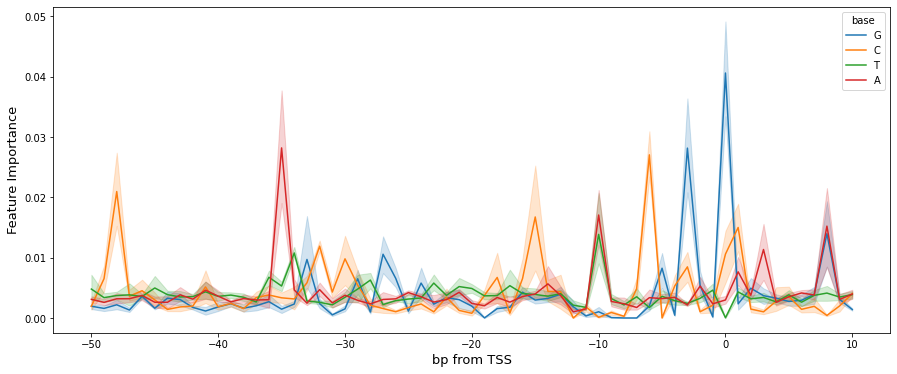

In [19]:
one_hot_feature_importance(x_oh_fi, y_oh_fi, models_to_try['RF'], scoring='r2', n_cv=5)

### Shapley Values

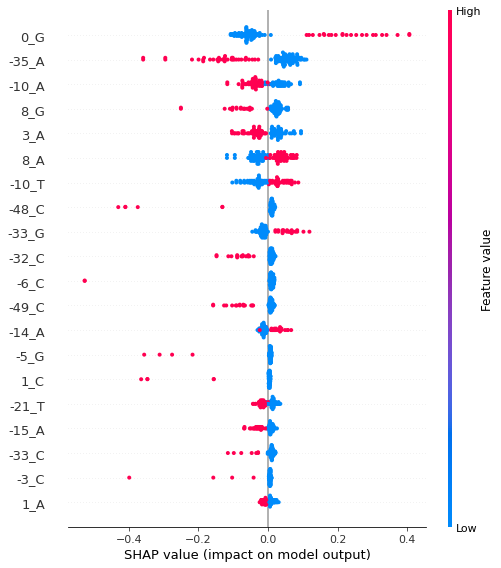

In [20]:
feature_importance(x_oh_fi, y_oh_fi, models_to_try['RF'])

# Genome Organization Features

In [21]:
gene_table_copy = m_florum.gene_table.copy()
go_table = m_florum.genome_organization_table(primary_tu=True, n_genome_bins=44)
gene_table_ml = pd.concat([gene_table_copy, go_table], axis='columns')
gene_table_ml.head()

,left,right,strand,KO,category,subcategory,subsubcategory,product_name,name,fpkm,...,tu_len,tu_gc,tu_order,tss_dist,tss_base,utr_len,utr_gc,box_10_seq,box_10_tss_dist,box_10_ext_gc
locus_tag,,,,,,,,,,,,,,,,,,,,,
peg.1,1.0,1332.0,1,K02313,Genetic Information Processing,DNA Maintenance,DNA replication and partition,"dnaA, chromosomal replication initiator protein",dnaA,192.793077,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peg.2,1560.0,2681.0,1,K02338,Genetic Information Processing,DNA Maintenance,DNA replication and partition,"dnaN, DNA polymerase III subunit beta [EC:2.7....",dnaN,642.952373,...,1179.0,0.229008,1.0,18.0,G,18.0,0.277778,GATAAT,8.0,0.333333
peg.3,2708.0,3682.0,-1,K03569,Cellular Processes,Cytoskeleton,Cytoskeleton proteins,"mreB, rod shape-determining protein MreB and r...",mreB,2046.205311,...,1032.0,0.252907,1.0,24.0,A,24.0,0.291667,TATACT,7.0,0.000000
peg.4,3751.0,4278.0,1,K05985,Genetic Information Processing,"Folding, Sorting and Degradation",Nucleases,"rnmV, ribonuclease M5 [EC:3.1.26.8]",rnmV,8.156475,...,1402.0,0.230385,1.0,22.0,A,22.0,0.227273,TATAAT,7.0,0.333333
peg.5,4280.0,5083.0,1,K02528,Genetic Information Processing,Translation,Ribosome biogenesis,"ksgA, 16S rRNA (adenine1518-N6/adenine1519-N6)...",ksgA,215.862583,...,1402.0,0.230385,2.0,551.0,A,22.0,0.227273,TATAAT,7.0,0.333333


## Replication Region

Text(0.35, 0.05, 'P = 5.761E-03')

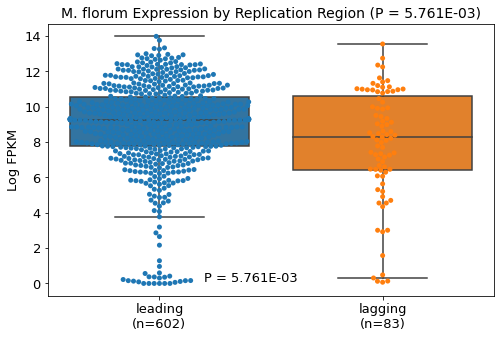

In [22]:
# get an actual significance comparison here
leading = gene_table_ml[gene_table_ml['rep_region'] == 'leading']['log_fpkm']
lagging = gene_table_ml[gene_table_ml['rep_region'] == 'lagging']['log_fpkm']

u_stat, p_value = mannwhitneyu(leading, lagging, alternative='two-sided')

_, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(x='rep_region', y='log_fpkm',
            data=gene_table_ml, fliersize=0, ax=ax)
sns.swarmplot(x='rep_region', y='log_fpkm',
            data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_xticklabels([f"{lab.get_text()}\n(n={gene_table_ml[gene_table_ml['rep_region'] == lab.get_text()].shape[0]})"
                       for lab in ax.get_xticklabels()])    
ax.set_ylabel('Log FPKM', fontsize=13)
ax.set_title(f'M. florum Expression by Replication Region (P = {p_value:.3E})', fontsize=14)
ax.text(0.35, 0.05, f'P = {p_value:.3E}', fontsize=13, transform=ax.transAxes)

## Distance to Origin

Text(0, 0.5, 'log[FPKM]')

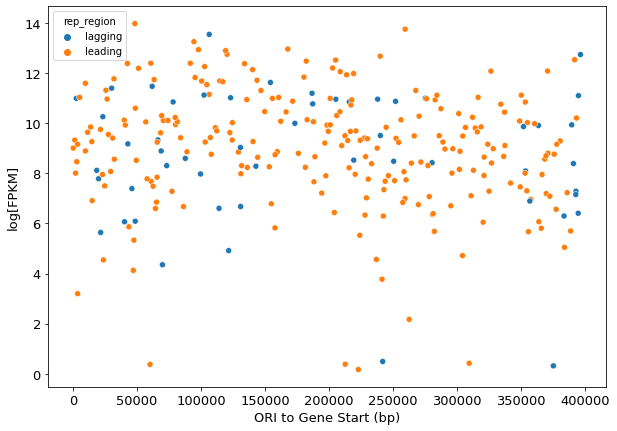

In [23]:
# only plot genes that are first in their TU to avoid multi-gene TU effects
to_plot_df = gene_table_ml[gene_table_ml['tu_order'] == 1]

_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='origin_dist', y='log_fpkm', hue='rep_region', data=to_plot_df, ax=ax,
               hue_order=['lagging', 'leading'])
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('ORI to Gene Start (bp)', fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)

## Genome Location

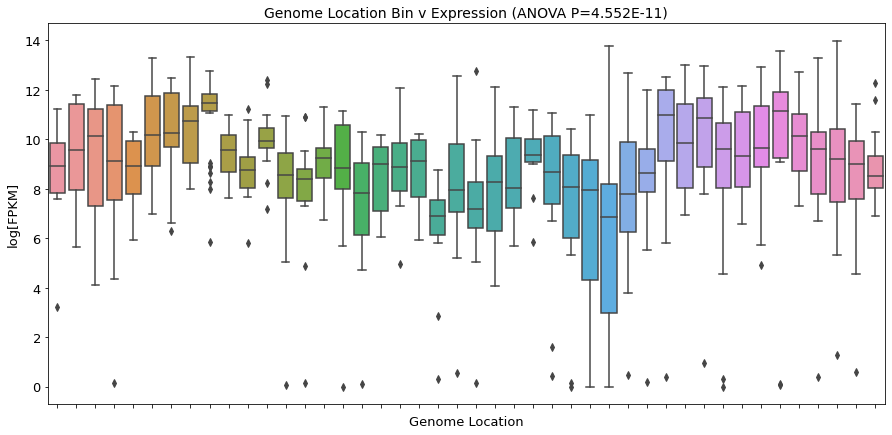

In [24]:
genome_loc_df = gene_table_ml[['genome_loc_cos', 'genome_loc_sin', 'log_fpkm']].copy()
genome_loc_df['sincos'] = genome_loc_df.apply(
    lambda row: str(row.genome_loc_cos) + str(row.genome_loc_sin), axis=1
)

exp_groups = []
for sincos, gloc_df in genome_loc_df.groupby('sincos'):
    exp_groups.append(gloc_df['log_fpkm'])
    
f, p = f_oneway(*exp_groups)

_, ax = plt.subplots(figsize=(15, 7))
sns.boxplot(x='sincos', y='log_fpkm', data=genome_loc_df, ax=ax, dodge=True)
ax.tick_params(axis='both', labelsize=13)
ax.tick_params(axis='x', rotation=90)
ax.set_xticklabels([])
ax.set_xlabel("Genome Location", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_title(f'Genome Location Bin v Expression (ANOVA P={p:.3E})', fontsize=14);

## Order in TU

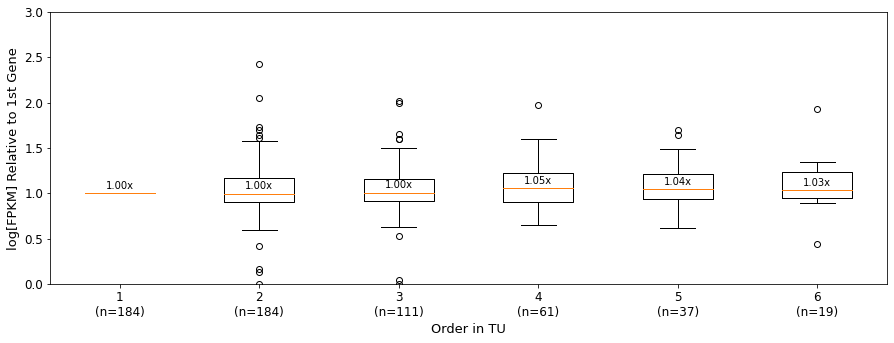

In [25]:
tu_rel_exps = {}

for tu_row in m_florum.tu_table.itertuples():

    tu_genes = m_florum._tu_to_genes[tu_row.Index]
    tu_gene_df = m_florum.gene_table[m_florum.gene_table.index.isin(tu_genes)]

    if tu_gene_df.shape[0] > 1:
        
        if tu_row.strand == 1:
            sorted_gene_df = tu_gene_df.sort_values(by='left')
        else:
            sorted_gene_df = tu_gene_df.sort_values(by='right', ascending=False)
        
        tu_gene_exps_rel = np.array(sorted_gene_df['log_fpkm']) / sorted_gene_df['log_fpkm'][0]
        
        for i, rel_exp in enumerate(tu_gene_exps_rel):
            if i in tu_rel_exps:
                tu_rel_exps[i].append(rel_exp)
            else:
                tu_rel_exps[i] = [rel_exp]
                
tu_rel_exps = {k: v for k, v in tu_rel_exps.items() if len(v) > 10}

_, ax = plt.subplots(figsize=(15, 5))

ax.boxplot(list(tu_rel_exps.values()))
ax.set_xticklabels([f'{i+1}\n(n={len(vals)})' for i, vals in enumerate(tu_rel_exps.values())])
ax.set_xlabel('Order in TU', fontsize=13)
ax.set_ylabel('log[FPKM] Relative to 1st Gene', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(bottom=0, top=3)
for i, vals in enumerate(tu_rel_exps.values()):
    med = np.median(vals)
    ax.text(i+1, med+0.05, f'{med:.2f}x', ha='center')

## Distance to TSS

(0.0, 3.0)

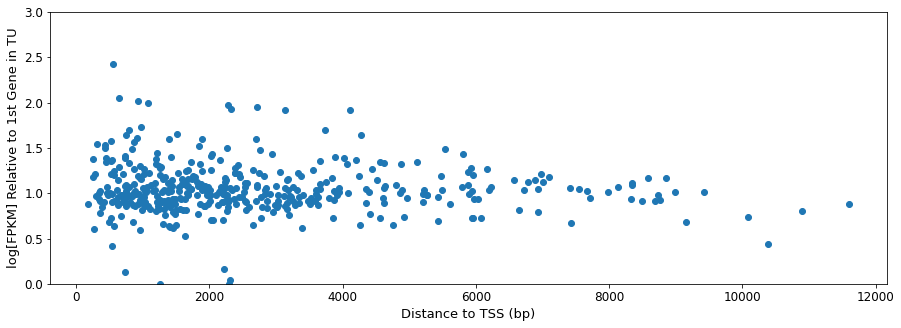

In [26]:
all_tss_dists = []
all_rel_exps_tss = []

for tu_row in m_florum.tu_table.itertuples():
    tu_genes = m_florum._tu_to_genes[tu_row.Index]
    tu_gene_df = m_florum.gene_table[m_florum.gene_table.index.isin(tu_genes)]
    if tu_gene_df.shape[0] > 1:
        
        if tu_row.strand == 1:
            sorted_gene_df = tu_gene_df.sort_values(by='left')
            tss_dists = sorted_gene_df['left'].values - tu_row.tss
        else:
            sorted_gene_df = tu_gene_df.sort_values(by='right', ascending=False)
            tss_dists = tu_row.tss - sorted_gene_df['right']
        
        tu_gene_exps_rel = np.array(sorted_gene_df['log_fpkm']) / sorted_gene_df['log_fpkm'][0]
        
        # ignore the first gene in the TU, this will just give us a bunch of y-values of 1 
        all_tss_dists += list(tss_dists[1:])
        all_rel_exps_tss += list(tu_gene_exps_rel[1:])
        
_, ax = plt.subplots(figsize=(15, 5))

ax.scatter(all_tss_dists, all_rel_exps_tss)
ax.set_xlabel('Distance to TSS (bp)', fontsize=13)
ax.set_ylabel('log[FPKM] Relative to 1st Gene in TU', fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(0, 3)

## TU Length

Text(0, 0.5, 'log[FPKM]')

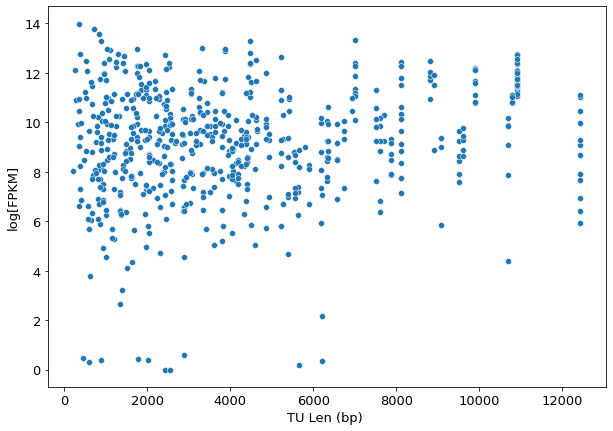

In [27]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='tu_len', y='log_fpkm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("TU Len (bp) ", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)

## TU GC Content

Text(0, 0.5, 'log[FPKM]')

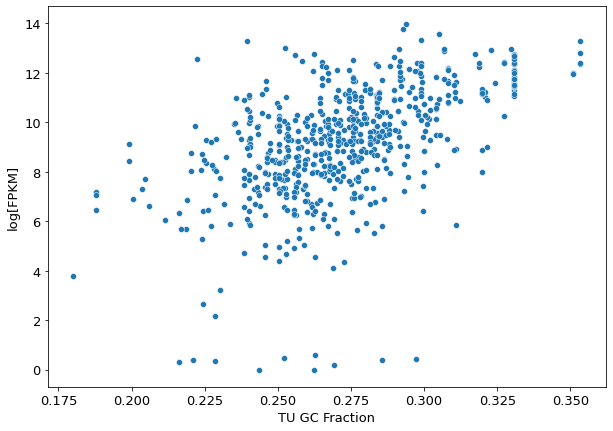

In [28]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='tu_gc', y='log_fpkm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("TU GC Fraction", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)

## TSS Base

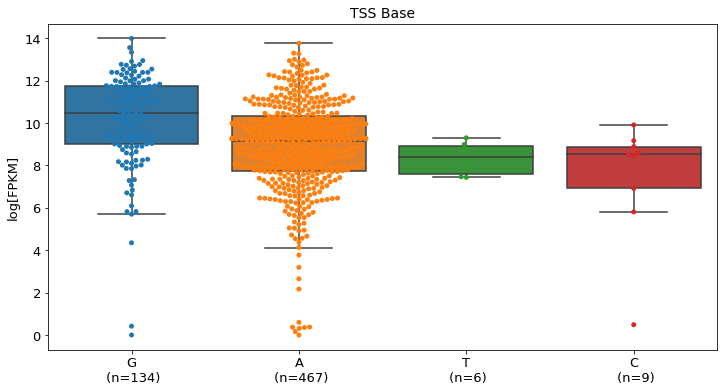

In [29]:
_, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='tss_base', y='log_fpkm', data=gene_table_ml, fliersize=0, ax=ax)
sns.swarmplot(x='tss_base', y='log_fpkm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_title(f"TSS Base", fontsize=14)
ax.set_xticklabels([
    f"{lab.get_text()}\n (n={gene_table_ml[gene_table_ml['tss_base'] == lab.get_text()].shape[0]})"
    for lab in ax.get_xticklabels()
]);

## 5' UTR 

### Length

Text(0, 0.5, 'log[FPKM]')

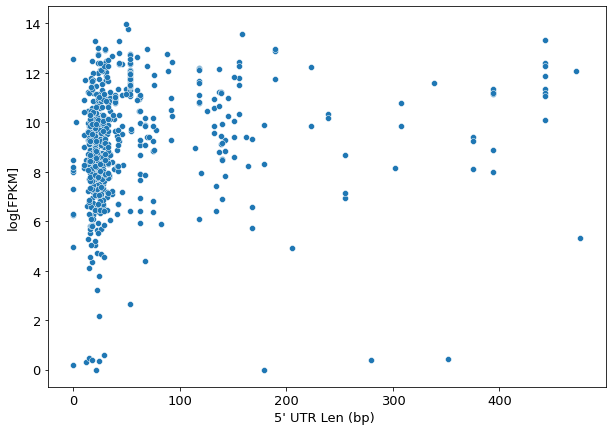

In [30]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='utr_len', y='log_fpkm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("5' UTR Len (bp) ", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)

### GC Content

Text(0, 0.5, 'log[FPKM]')

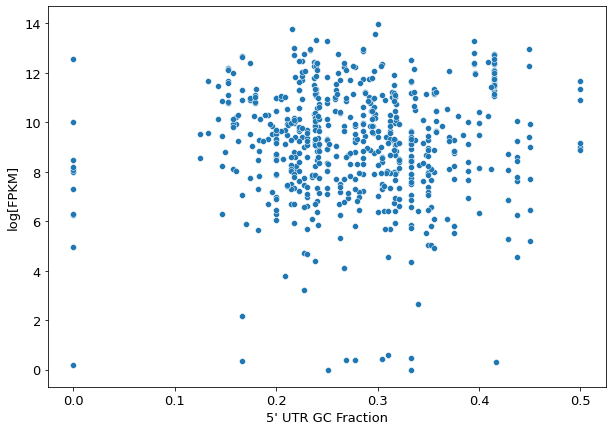

In [31]:
_, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x='utr_gc', y='log_fpkm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel("5' UTR GC Fraction", fontsize=13)
ax.set_ylabel('log[FPKM]', fontsize=13)

## -10 Box

### Sequence

9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


Text(0.5, 1.0, '-10 Box Sequence (n=22; 11 with >5 genes shown)')

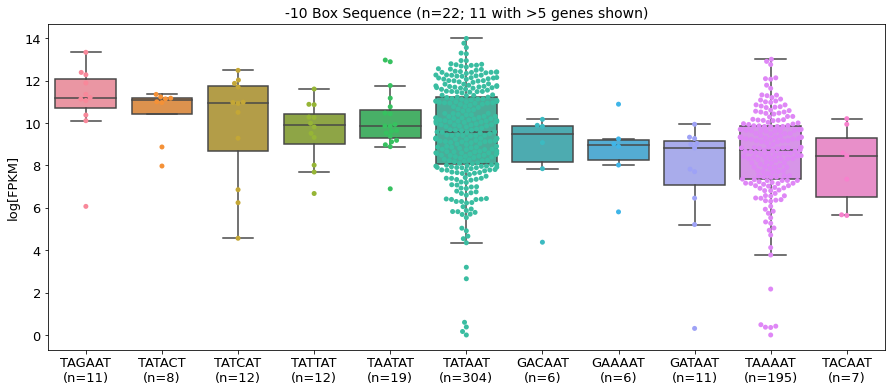

In [32]:
box_df = gene_table_ml[['box_10_seq', 'log_fpkm']].dropna()

box_10_dfs = []

for _, b10seq_df in box_df.groupby('box_10_seq'):
    if b10seq_df.shape[0] > 5:
        box_10_dfs.append(b10seq_df)
        
box_10_dfs = sorted(box_10_dfs, key=lambda df: df['log_fpkm'].median(), reverse=True)
box_10_df = pd.concat(box_10_dfs)

_, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='box_10_seq', y='log_fpkm', data=box_10_df, fliersize=0, ax=ax)
sns.swarmplot(x='box_10_seq', y='log_fpkm', data=box_10_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('')
ax.set_ylabel('log[FPKM]', fontsize=13)
ax.set_xticklabels([f"{lab.get_text()}\n(n={box_10_df[box_10_df['box_10_seq'] == lab.get_text()].shape[0]})"
                   for lab in ax.get_xticklabels()])
ax.set_title(f"-10 Box Sequence (n={len(box_df['box_10_seq'].unique())}; 11 with >5 genes shown)", fontsize=14)

### Distance to TSS

Text(0, 0.5, 'log[FPKM]')

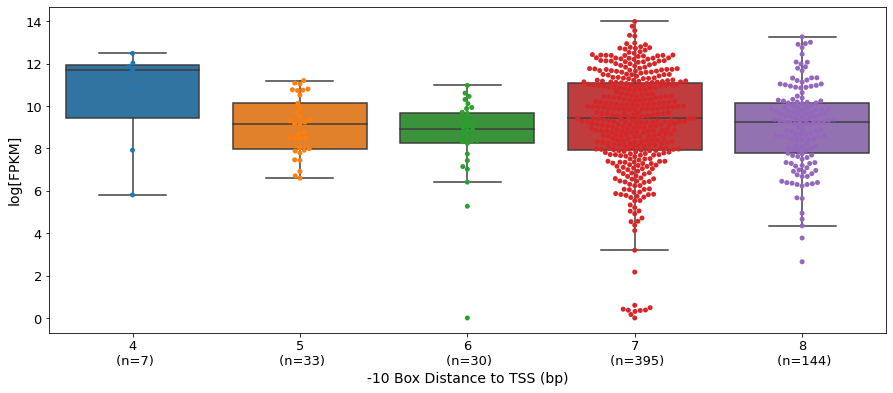

In [33]:
box_dist_df = gene_table_ml[['box_10_tss_dist', 'log_fpkm']].dropna()
box_dist_df = box_dist_df[box_dist_df['box_10_tss_dist'] < 9]

_, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='box_10_tss_dist', y='log_fpkm', data=box_dist_df, fliersize=0, ax=ax)
sns.swarmplot(x='box_10_tss_dist', y='log_fpkm', data=box_dist_df, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('-10 Box Distance to TSS (bp)', fontsize=14)
ax.set_xticklabels([
    f"{int(float(lab.get_text()))}\n (n={box_dist_df[box_dist_df['box_10_tss_dist'] == float(lab.get_text())].shape[0]})"
    for lab in ax.get_xticklabels()
])
ax.set_ylabel('log[FPKM]', fontsize=14)

### Extended Box GC Content

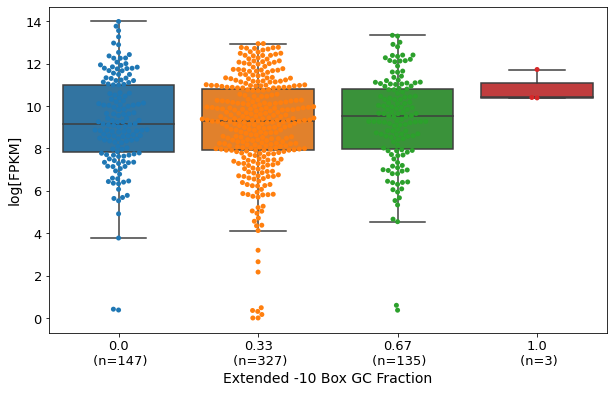

In [34]:
_, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='box_10_ext_gc', y='log_fpkm', fliersize=0, data=gene_table_ml, ax=ax)
sns.swarmplot(x='box_10_ext_gc', y='log_fpkm', data=gene_table_ml, ax=ax)
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('Extended -10 Box GC Fraction', fontsize=14)
ax.set_ylabel('log[FPKM]', fontsize=14)
ax.set_xticklabels([
    f"{np.round(float(lab.get_text()), decimals=2)}\n (n={gene_table_ml[gene_table_ml['box_10_ext_gc'] == float(lab.get_text())].shape[0]})"
    for lab in ax.get_xticklabels()
]);

# Modeling - Genome Organization Features

## Prepare Feature Matrices

In [35]:
X = gene_table_ml.drop(columns=['left', 'right', 'strand', 'KO', 'category', 'subcategory', 'subsubcategory',
                               'product_name', 'name', 'log_fpkm', 'primary_tu']).dropna()
y = X['fpkm']
X = X.drop(columns=['fpkm'])

X_go_all = pd.get_dummies(X.copy())
X_no_box10 = pd.get_dummies(X.copy().drop(columns=['box_10_seq']))

Xy_to_try_go = {
    'all': (X_go_all, y),
    'no_box10': (X_no_box10, y)
}

## Set Aside Lockbox Data

In [36]:
Xy_train_go, Xy_lockbox_go = create_train_and_lockbox_sets(Xy_to_try_go)

## Profile Models

In [37]:
models_to_try = {
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RF': RandomForestRegressor(n_jobs=4),
    'NN': MLPRegressor()
}

ElasticNet: all__X_raw__y_raw
ElasticNet: all__X_raw__y_standard
ElasticNet: all__X_raw__y_log
ElasticNet: all__X_raw__y_standard_log
ElasticNet: all__X_standard__y_raw
ElasticNet: all__X_standard__y_standard
ElasticNet: all__X_standard__y_log
ElasticNet: all__X_standard__y_standard_log
ElasticNet: no_box10__X_raw__y_raw
ElasticNet: no_box10__X_raw__y_standard
ElasticNet: no_box10__X_raw__y_log
ElasticNet: no_box10__X_raw__y_standard_log
ElasticNet: no_box10__X_standard__y_raw
ElasticNet: no_box10__X_standard__y_standard
ElasticNet: no_box10__X_standard__y_log
ElasticNet: no_box10__X_standard__y_standard_log
SVR: all__X_raw__y_raw
SVR: all__X_raw__y_standard
SVR: all__X_raw__y_log
SVR: all__X_raw__y_standard_log
SVR: all__X_standard__y_raw
SVR: all__X_standard__y_standard
SVR: all__X_standard__y_log
SVR: all__X_standard__y_standard_log
SVR: no_box10__X_raw__y_raw
SVR: no_box10__X_raw__y_standard
SVR: no_box10__X_raw__y_log
SVR: no_box10__X_raw__y_standard_log
SVR: no_box10__X_standard_

80.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
80.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


(         model                                    xy  train_score  val_score
 0   ElasticNet                     all__X_raw__y_raw     0.117802   0.261666
 1   ElasticNet                     all__X_raw__y_raw     0.151063   0.115180
 2   ElasticNet                     all__X_raw__y_raw     0.157170   0.099413
 3   ElasticNet                     all__X_raw__y_raw     0.182039   0.031870
 4   ElasticNet                     all__X_raw__y_raw     0.147760   0.136898
 ..         ...                                   ...          ...        ...
 0           NN  no_box10__X_standard__y_standard_log     0.619783   0.179282
 1           NN  no_box10__X_standard__y_standard_log     0.616650   0.253935
 2           NN  no_box10__X_standard__y_standard_log     0.644769   0.263910
 3           NN  no_box10__X_standard__y_standard_log     0.636643   0.012313
 4           NN  no_box10__X_standard__y_standard_log     0.605173   0.365081
 
 [320 rows x 4 columns],
 <AxesSubplot:ylabel='Training r2'>,


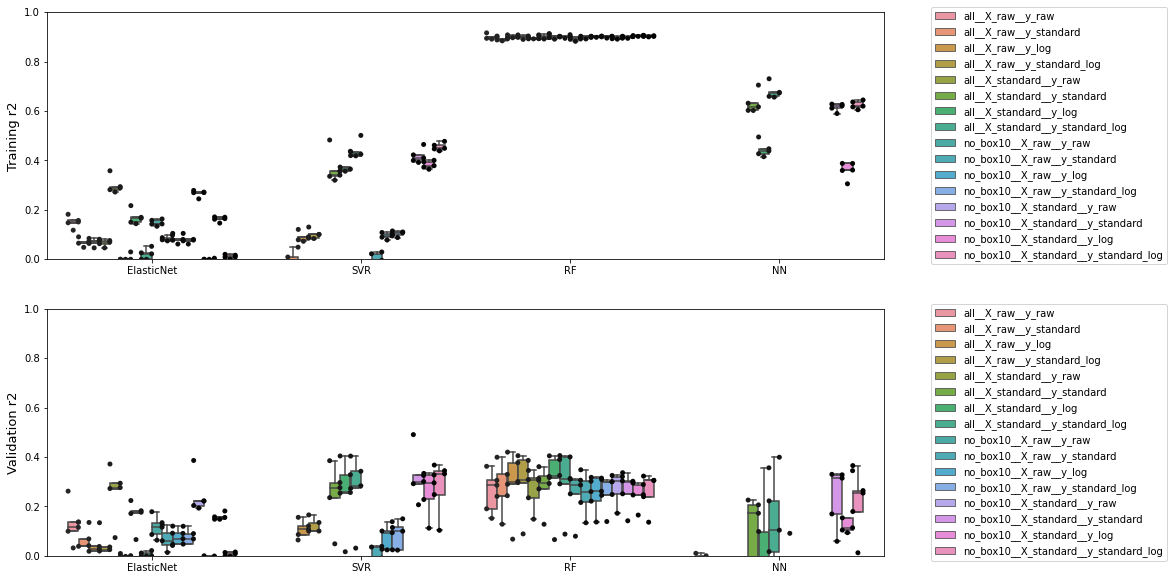

In [38]:
profile_xy_and_models(Xy_train_go, models_to_try, scoring='r2', n_cv=5,
                      x_preprocessing=['standard'], y_preprocessing=['standard', 'log', 'standard_log'],
                      verbose=True)

## Feature Importances

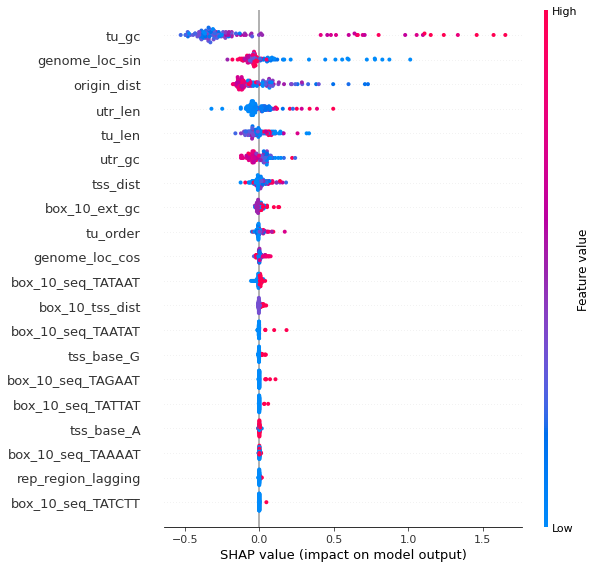

In [39]:
x_go_fi_raw = Xy_train_go['all'][0]
x_go_fi = pd.DataFrame(
    StandardScaler().fit_transform(x_go_fi_raw),
    columns=x_go_fi_raw.columns,
    index=x_go_fi_raw.index
)
y_go_fi = StandardScaler().fit_transform(
    Xy_train_go['all'][1].values.reshape(-1, 1)).flatten()

feature_importance(x_go_fi, y_go_fi, models_to_try['RF'])